# Download do Dataset Fruits 360 e Preprocessamento

In [ ]:
!wget - c 'https://github.com/Horea94/Fruit-Images-Dataset/archive/refs/heads/master.zip' --no-check-certificate

--2022-12-20 15:37:59--  http://-/
Resolving - (-)... failed: Name or service not known.
wget: unable to resolve host address ‘-’
--2022-12-20 15:37:59--  http://c/
Resolving c (c)... failed: Name or service not known.
wget: unable to resolve host address ‘c’
--2022-12-20 15:37:59--  https://github.com/Horea94/Fruit-Images-Dataset/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/Horea94/Fruit-Images-Dataset/zip/refs/heads/master [following]
--2022-12-20 15:37:59--  https://codeload.github.com/Horea94/Fruit-Images-Dataset/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.121.9
Connecting to codeload.github.com (codeload.github.com)|140.82.121.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zi

In [ ]:
!unzip /content/master.zip

Streaming output truncated to the last 5000 lines.
  inflating: Fruit-Images-Dataset-master/Training/Tomato 3/147_100.jpg  
  inflating: Fruit-Images-Dataset-master/Training/Tomato 3/148_100.jpg  
  inflating: Fruit-Images-Dataset-master/Training/Tomato 3/149_100.jpg  
  inflating: Fruit-Images-Dataset-master/Training/Tomato 3/150_100.jpg  
  inflating: Fruit-Images-Dataset-master/Training/Tomato 3/151_100.jpg  
  inflating: Fruit-Images-Dataset-master/Training/Tomato 3/152_100.jpg  
  inflating: Fruit-Images-Dataset-master/Training/Tomato 3/153_100.jpg  
  inflating: Fruit-Images-Dataset-master/Training/Tomato 3/154_100.jpg  
  inflating: Fruit-Images-Dataset-master/Training/Tomato 3/155_100.jpg  
  inflating: Fruit-Images-Dataset-master/Training/Tomato 3/156_100.jpg  
  inflating: Fruit-Images-Dataset-master/Training/Tomato 3/157_100.jpg  
  inflating: Fruit-Images-Dataset-master/Training/Tomato 3/158_100.jpg  
  inflating: Fruit-Images-Dataset-master/Training/Tomato 3/159_100.jpg  


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
import os
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout, Lambda
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint

In [ ]:
# initial learning rate
learning_rate = 0.1 

# once the learning rate reaches this value , do not decrease it further
min_learning_rate = 0.00001 

# the factor used when reducing the learning rate -> learning_rate *= learning_rate_reduction_factor
learning_rate_reduction_factor = 0.5 

# how many epochs to wait before reducing the learning rate when the loss plateaus
patience = 3 

# controls the amount of logging done during training and testing:
# 0 - none , 1 - reports metrics after each batch , 2 - reports metrics after each epoch
verbose = 1

# width and height of the used images
image_size = (100 , 100)

# the expected input shape for the trained models; since the images in the Fruit -360 are 100 x 100
# RGB images , this is the required input shape
input_shape = (100 , 100, 3) 

# set this to true if you want load the label names from a file; uses the label_file defined below;
# the file should contain the names of the used labels , each label on a separate line
use_label_file = False

label_file = "labels.txt"

# relative path to the Fruit - Images -Dataset folder

base_dir = "/content/Fruit-Images-Dataset-master"

test_dir = os.path.join(base_dir , "Test")

train_dir = os.path.join(base_dir , "Training")

# root folder in which to save the the output files; the files will be under output_files/model_name
output_dir = "output_files"

In [ ]:
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

  if use_label_file:
    with open(label_file , "r") as f:
      labels = [x.strip() for x in f.readlines()]
  else:
    labels = os.listdir(train_dir)
num_classes = len(labels)

In [ ]:
# create 2 charts , one for accuracy , one for loss;
# to show the evolution of these two metrics during the training process
def plot_model_history(model_history , out_path=""):
  fig, axs = plt.subplots(1, 2, figsize=(15 , 5))
# summarize history for accuracy
  axs[0].plot(range(1, len(model_history.history["acc"]) + 1), model_history.history["acc"])
  axs[0].set_title("Model Accuracy")
  axs[0].set_ylabel("Accuracy")
  axs[0].set_xlabel("Epoch")
  axs[0].set_xticks(np.arange(1, len(model_history.history["acc"]) + 1), len(model_history.history["acc"]))
  axs[0].legend(["train"], loc="best")

# summarize history for loss
  axs[1].plot(range(1, len(model_history.history["loss"]) + 1), model_history.history["loss"])
  axs[1].set_title("Model Loss")
  axs[1].set_ylabel("Loss")
  axs[1].set_xlabel("Epoch")
  axs[1].set_xticks(np.arange(1, len(model_history.history["loss"]) + 1), len(model_history.history["loss"]))
  axs[1].legend(["train"], loc="best")
  
# save the graph in a file called "acc.png" to be available for later;
# the model_name is provided when creating and training a model
  if out_path:
    plt.savefig(out_path + "/acc.png")
  plt.show()

In [ ]:
# create a confusion matrix to visually represent incorrectly classified images
def plot_confusion_matrix(y_true , y_pred , classes , out_path=""):
  cm = confusion_matrix(y_true , y_pred)
  df_cm = pd.DataFrame(cm, index=[i for i in classes], columns=[i for i in classes])
  plt.figure(figsize=(40 , 40))
  ax = sn.heatmap(df_cm , annot=True , square=True ,fmt="d", linewidths=.2, cbar_kws={"shrink":0.8})
  if out_path:
    plt.savefig(out_path + "/ confusion_matrix .png") 
# as in the plot_model_history , thematrix is saved in a file called "model_name_confusion_matrix.png"
  return ax

In [ ]:
# Randomly changes hue and saturation of the image to simulate variable lighting conditions

def augment_image(x):
  x = tf.image.random_saturation(x, 0.9, 1.2)
  x = tf.image.random_hue(x, 0.02)
  return x

In [ ]:
def build_data_generators(train_folder, test_folder, labels=None, image_size=(100 , 100), batch_size=50):
  train_datagen = ImageDataGenerator(width_shift_range=0.0, height_shift_range=0.0,
                                     zoom_range=0.0, horizontal_flip=True, vertical_flip=True,
                                     preprocessing_function=augment_image) 
  
  # augmentation is done only on the train set
  
  test_datagen = ImageDataGenerator()

  train_gen = train_datagen.flow_from_directory(train_folder , target_size=image_size ,
                                                class_mode="sparse", batch_size=batch_size,
                                                shuffle=True , subset="training", classes=labels)
  test_gen = test_datagen.flow_from_directory(test_folder , target_size=image_size 
                                              , class_mode="sparse", batch_size=batch_size,
                                              shuffle=False, subset=None, classes=labels)
  return train_gen , test_gen

In [ ]:
def convert_to_hsv_and_grayscale(x):
  hsv = tf.image.rgb_to_hsv(x)
  gray = tf.image.rgb_to_grayscale(x)
  rez = tf.concat([hsv, gray], axis=-1)
  return rez

In [ ]:
def network(input_shape , num_classes):
  img_input = Input(shape=input_shape , name="data")
  x = Lambda(convert_to_hsv_and_grayscale)(img_input)
  x = Conv2D(16, (5, 5), strides=(1, 1), padding="same", name="conv1")(x)
  x = Activation("relu", name="conv1_relu")(x)
  x = MaxPooling2D((2, 2), strides=(2, 2), padding="valid", name="pool1")(x)
  x = Conv2D(32, (5, 5), strides=(1, 1), padding="same", name="conv2")(x)
  x = Activation("relu", name="conv2_relu")(x)
  x = MaxPooling2D((2, 2), strides=(2, 2), padding="valid", name="pool2")(x)
  x = Conv2D(64, (5, 5), strides=(1, 1), padding="same", name="conv3")(x)
  x = Activation("relu", name="conv3_relu")(x)
  x = MaxPooling2D((2, 2), strides=(2, 2), padding="valid", name="pool3")(x)
  x = Conv2D(128 , (5, 5), strides=(1, 1), padding="same", name="conv4")(x)
  x = Activation("relu", name="conv4_relu")(x)
  x = MaxPooling2D((2, 2), strides=(2, 2), padding="valid", name="pool4")(x)
  x = Flatten()(x)
  x = Dense(1024 , activation="relu", name="fcl1")(x)
  x = Dropout(0.2)(x)
  x = Dense(256 , activation="relu", name="fcl2")(x)
  x = Dropout(0.2)(x)
  out = Dense(num_classes , activation="softmax", name="predictions")(x)
  rez = Model(inputs=img_input , outputs=out)
  return rez

In [ ]:
#!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 15.7 MB/s 
     |████████████████████████████████| 174 kB 73.1 MB/s 
     |████████████████████████████████| 182 kB 73.3 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
     |████████████████████████████████| 173 kB 78.7 MB/s 
     |████████████████████████████████| 168 kB 77.7 MB/s 
     |████████████████████████████████| 168 kB 87.7 MB/s 
     |████████████████████████████████| 166 kB 85.5 MB/s 
     |████████████████████████████████| 166 kB 84.2 MB/s 
     |████████████████████████████████| 162 kB 85.2 MB/s 
     |████████████████████████████████| 162 kB 86.2 MB/s 
     |████████████████████████████████| 158 kB 77.7 MB/s 
     |████████████████████████████████| 157 kB 72.8 MB/s 
     |████████████████████████████████| 157 kB 79.6 MB/s 
     |████████████████████████████████| 157 kB 88.0 MB/s 
     |███████████████████████████

In [ ]:
#import wandb
#!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
#from wandb.keras import WandbCallback

In [ ]:
#wandb.init(project="Uni3", name="Estrutura Experimentos")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: talesv. Use `wandb login --relogin` to force relogin


In [ ]:
def train_and_evaluate_model(model , name="", epochs=10, batch_size=50, verbose=verbose , useCkpt=False):
  print(model.summary())
  model_out_dir = os.path.join(output_dir , name)
  if not os.path.exists(model_out_dir):
    os.makedirs(model_out_dir)
  if useCkpt:
    model.load_weights(model_out_dir + "/model.h5")

  trainGen , testGen = build_data_generators(train_dir , test_dir , labels=labels ,
                                             image_size=image_size , batch_size=batch_size)

  optimizer = Adadelta(lr=learning_rate)
  model.compile(optimizer=optimizer , loss="sparse_categorical_crossentropy", metrics=["acc"])
  learning_rate_reduction = ReduceLROnPlateau(monitor="loss", patience=patience,
                                              verbose=verbose , factor=learning_rate_reduction_factor,
                                              min_lr=min_learning_rate)
  save_model = ModelCheckpoint(filepath=model_out_dir + "/model.h5", monitor="loss",verbose=verbose,
                               save_best_only=True, save_weights_only=False , mode="min",save_freq="epoch")
  
  history = model.fit(trainGen, epochs=epochs, steps_per_epoch=(trainGen.n // batch_size) + 1,
                      verbose=verbose , callbacks=[learning_rate_reduction , save_model])

  model.load_weights(model_out_dir + "/model.h5")

  trainGen.reset()
  loss_t , accuracy_t = model.evaluate(trainGen, steps=(trainGen.n // batch_size) + 1, verbose=verbose)
  loss , accuracy = model.evaluate(testGen , steps=(testGen.n // batch_size) + 1, verbose=verbose)
  print("Train: accuracy = %f ; loss_v = %f" % (accuracy_t , loss_t))
  print("Test: accuracy = %f ; loss_v = %f" % (accuracy , loss))
  plot_model_history(history , out_path=model_out_dir)
  testGen.reset()
  y_pred = model.predict(testGen , steps=(testGen.n // batch_size) + 1, verbose=verbose)
  y_true = testGen.classes[testGen.index_array]
  plot_confusion_matrix(y_true , y_pred.argmax(axis=-1), labels , out_path=model_out_dir)
  class_report = classification_report(y_true, y_pred.argmax(axis=-1), target_names=labels)

  with open(model_out_dir + "/ classification_report .txt", "w") as text_file:
    text_file.write("%s" % class_report)

['Pineapple Mini', 'Banana Red', 'Apple Braeburn', 'Raspberry', 'Apple Crimson Snow', 'Walnut', 'Nut Forest', 'Mangostan', 'Dates', 'Onion Red', 'Mango Red', 'Fig', 'Passion Fruit', 'Papaya', 'Cantaloupe 2', 'Pepper Red', 'Lychee', 'Lemon Meyer', 'Pear Abate', 'Nut Pecan', 'Pepper Yellow', 'Onion White', 'Pear Williams', 'Pear Kaiser', 'Peach 2', 'Quince', 'Grape White', 'Kiwi', 'Potato Sweet', 'Potato White', 'Apple Red Yellow 2', 'Pear Stone', 'Tomato 3', 'Plum 2', 'Pineapple', 'Apple Golden 3', 'Apple Red Delicious', 'Chestnut', 'Apple Granny Smith', 'Tomato Yellow', 'Pear', 'Potato Red Washed', 'Cherry 1', 'Salak', 'Onion Red Peeled', 'Cocos', 'Melon Piel de Sapo', 'Tomato 4', 'Pear Forelle', 'Banana', 'Avocado ripe', 'Corn Husk', 'Rambutan', 'Clementine', 'Pomelo Sweetie', 'Cucumber Ripe 2', 'Tomato not Ripened', 'Pepper Green', 'Pepino', 'Grapefruit White', 'Cherry Rainier', 'Corn', 'Limes', 'Kumquats', 'Tomato Maroon', 'Mandarine', 'Tomato Heart', 'Physalis with Husk', 'Lemon', 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adadelta.py:77: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adadelta, self).__init__(name, **kwargs)


Epoch 1/10
1354/1354 [==============================] - ETA: 0s - loss: 2.5387 - acc: 0.4100
Epoch 1: loss improved from inf to 2.53871, saving model to output_files/fruit -360 model/model.h5
1354/1354 [==============================] - 186s 131ms/step - loss: 2.5387 - acc: 0.4100 - lr: 0.1000
Epoch 2/10
1354/1354 [==============================] - ETA: 0s - loss: 0.4755 - acc: 0.8550
Epoch 2: loss improved from 2.53871 to 0.47548, saving model to output_files/fruit -360 model/model.h5
1354/1354 [==============================] - 176s 130ms/step - loss: 0.4755 - acc: 0.8550 - lr: 0.1000
Epoch 3/10
1354/1354 [==============================] - ETA: 0s - loss: 0.2076 - acc: 0.9349
Epoch 3: loss improved from 0.47548 to 0.20765, saving model to output_files/fruit -360 model/model.h5
1354/1354 [==============================] - 179s 132ms/step - loss: 0.2076 - acc: 0.9349 - lr: 0.1000
Epoch 4/10
1354/1354 [==============================] - ETA: 0s - loss: 0.1200 - acc: 0.9620
Epoch 4: loss 

<ipython-input-7-36db8eb050a1>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1, len(model_history.history["acc"]) + 1), len(model_history.history["acc"]))
<ipython-input-7-36db8eb050a1>:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1, len(model_history.history["loss"]) + 1), len(model_history.history["loss"]))


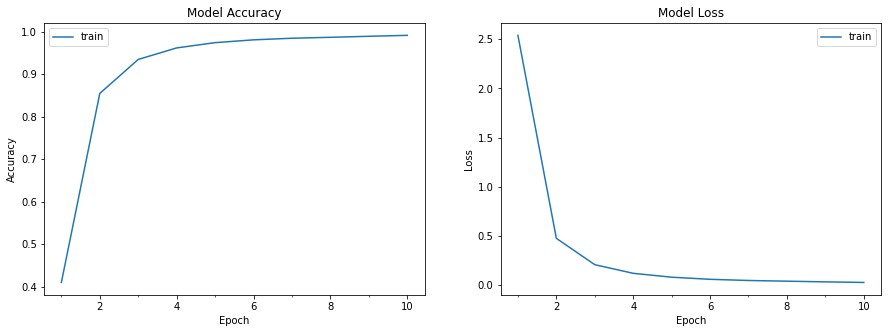

454/454 [==============================] - 12s 27ms/step


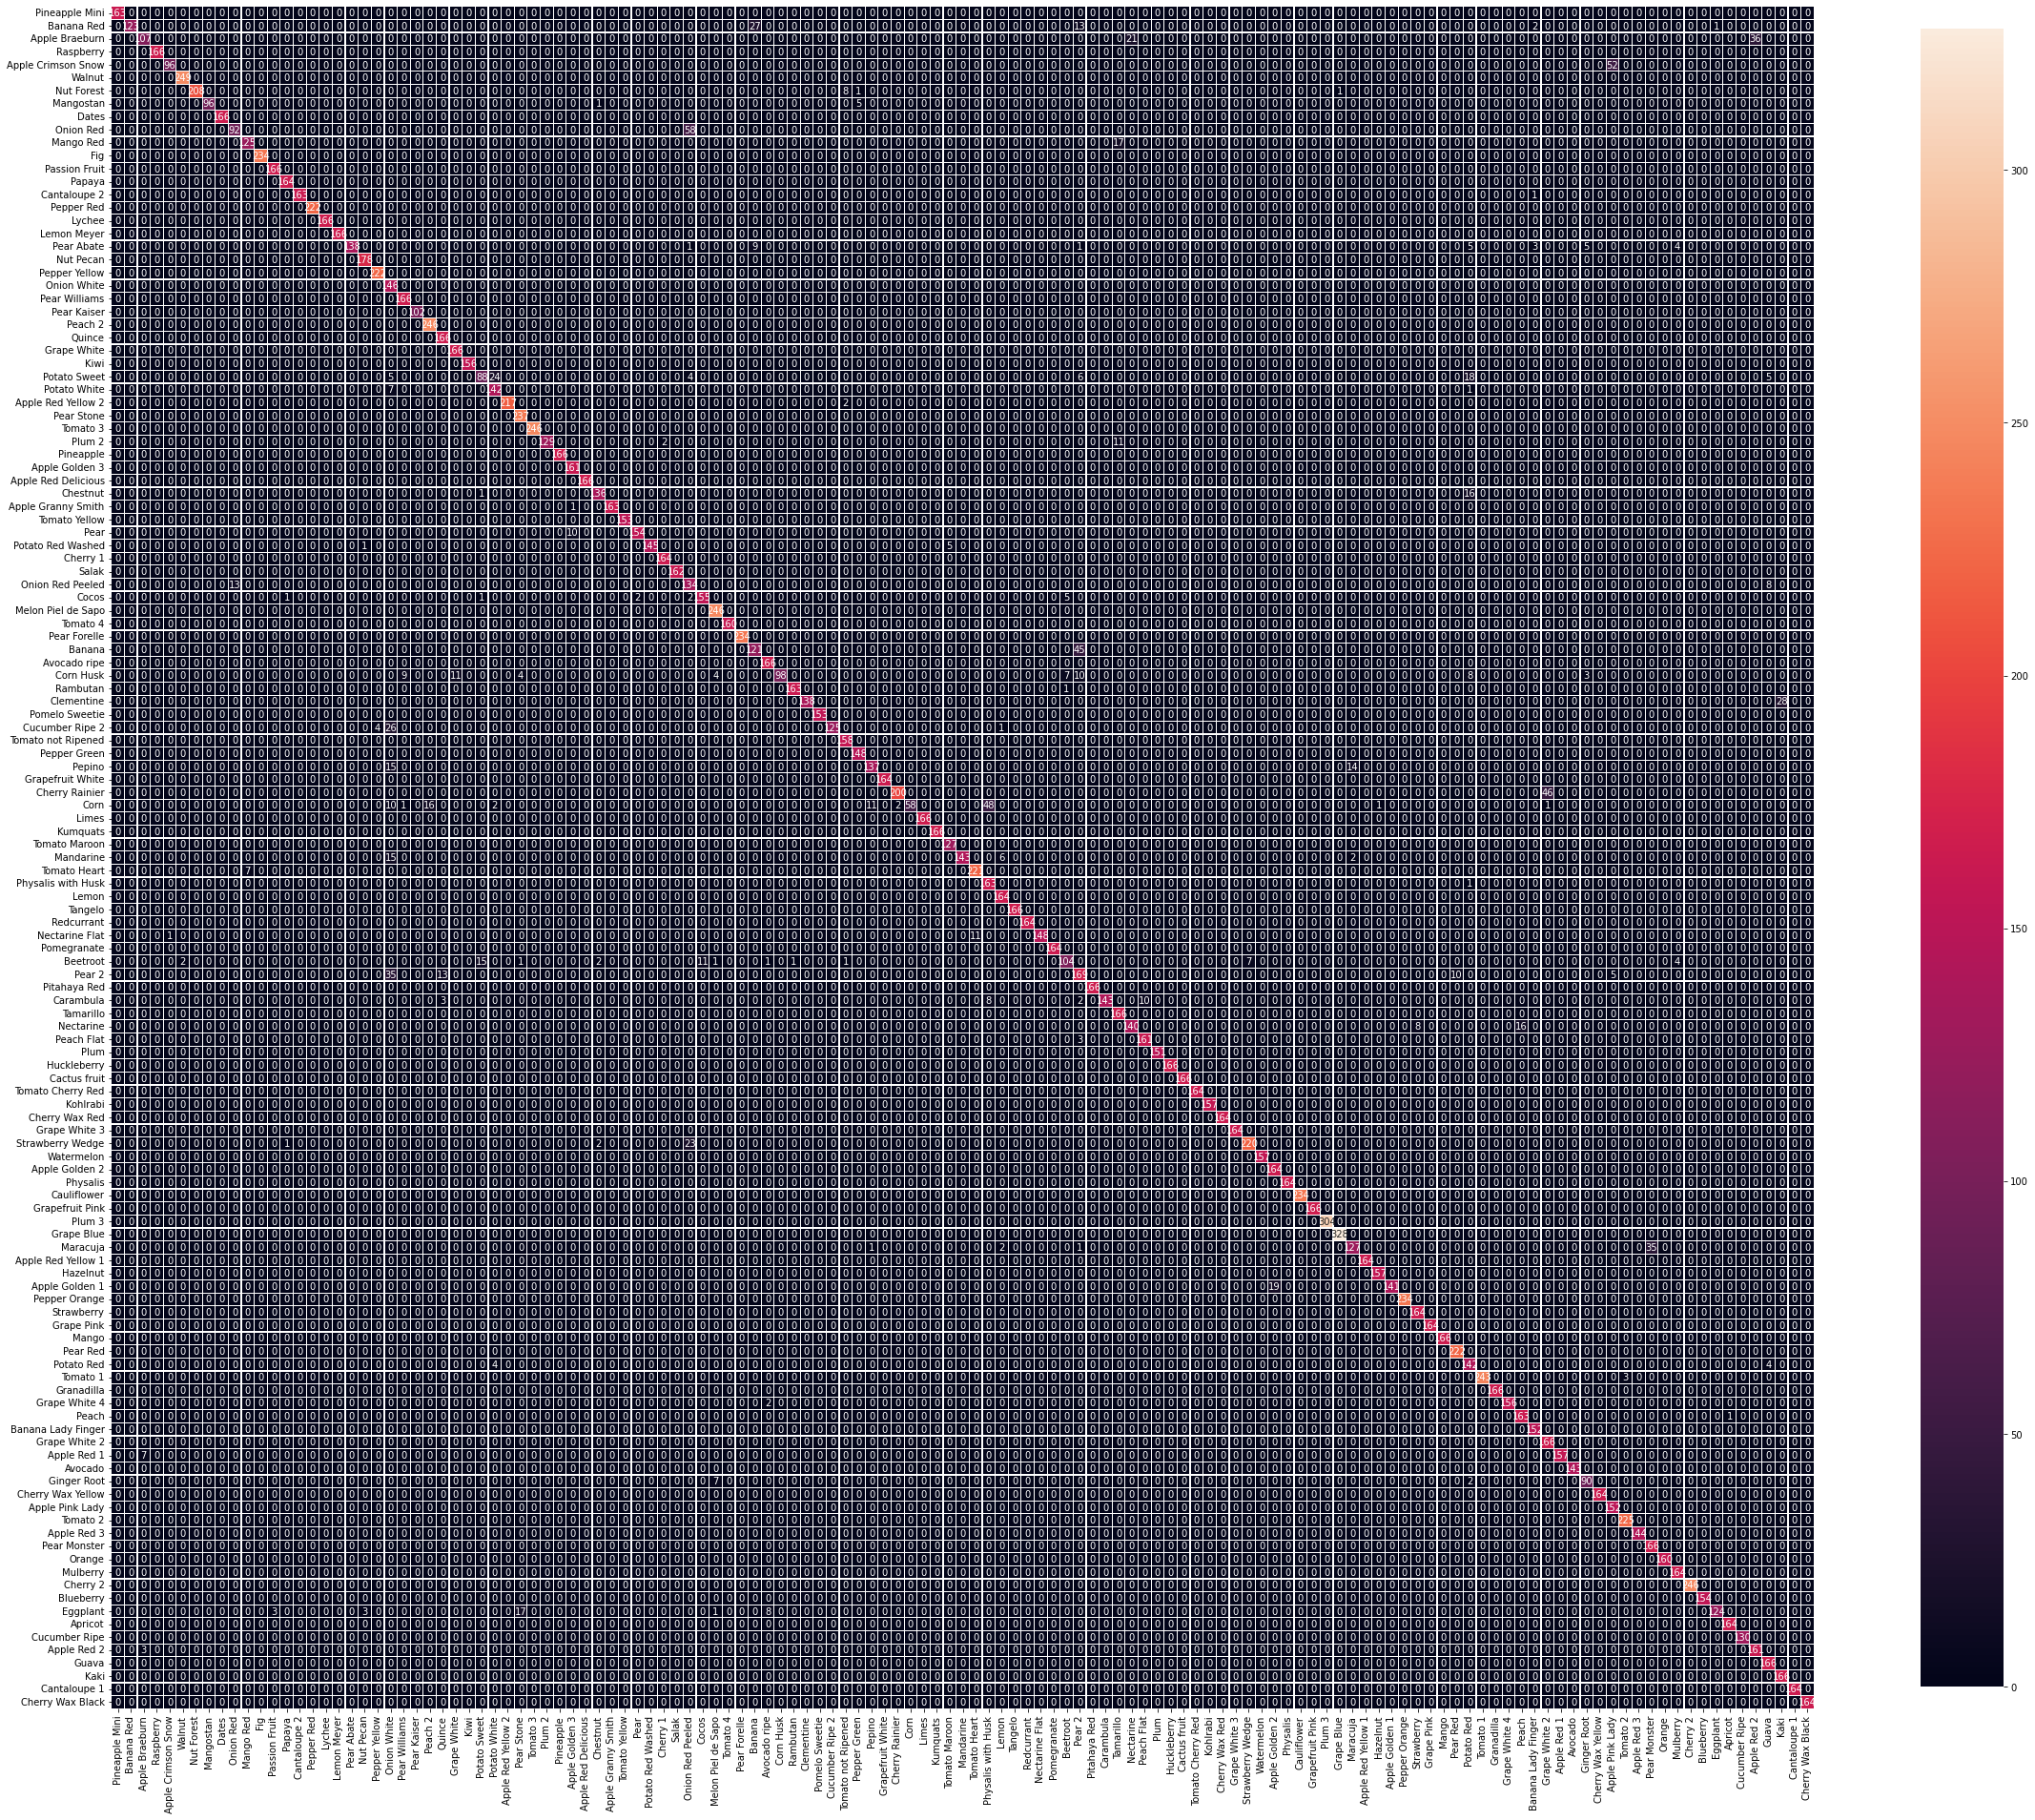

In [ ]:
print(labels)
print(num_classes)
model = network(input_shape=input_shape , num_classes=num_classes)
train_and_evaluate_model(model , name="fruit -360 model")

# Transfer Learning

## VGG16

In [ ]:
#wandb.init(project="Uni3", name="VGG16")

In [ ]:
# a fully connect network
class FCHeadNet:
	@staticmethod
	def build(baseModel, classes):
		# initialize the head model that will be placed on top of
		# the base, then add a FC layer
		headModel = baseModel.output
		headModel = Flatten(name="flatten")(headModel)
		headModel = Dense(1024, activation="relu")(headModel)
		headModel = Dropout(0.2)(headModel)
		headModel = Dense(256, activation="relu")(headModel)
		headModel = Dropout(0.2)(headModel)
		# add a softmax layer
		headModel = Dense(classes, activation="softmax")(headModel)

		# return the model
		return headModel


In [ ]:
from tensorflow.keras.applications import VGG16

vgg16 = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(100, 100, 3)))

fullyConnected = FCHeadNet.build(vgg16, num_classes)

model_VGG16 = Model(inputs=vgg16.input, outputs=fullyConnected)
for layer in vgg16.layers:
	layer.trainable = False

model_VGG16.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                            

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0   

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adadelta.py:77: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adadelta, self).__init__(name, **kwargs)


1354/1354 [==============================] - ETA: 0s - loss: 2.9251 - acc: 0.4455
Epoch 1: loss improved from inf to 2.92508, saving model to output_files/fruit -360 VGG16/model.h5
1354/1354 [==============================] - 233s 171ms/step - loss: 2.9251 - acc: 0.4455 - lr: 0.1000
Epoch 2/10
1354/1354 [==============================] - ETA: 0s - loss: 0.5055 - acc: 0.8615
Epoch 2: loss improved from 2.92508 to 0.50550, saving model to output_files/fruit -360 VGG16/model.h5
1354/1354 [==============================] - 237s 175ms/step - loss: 0.5055 - acc: 0.8615 - lr: 0.1000
Epoch 3/10
1354/1354 [==============================] - ETA: 0s - loss: 0.2225 - acc: 0.9342
Epoch 3: loss improved from 0.50550 to 0.22253, saving model to output_files/fruit -360 VGG16/model.h5
1354/1354 [==============================] - 241s 178ms/step - loss: 0.2225 - acc: 0.9342 - lr: 0.1000
Epoch 4/10
1354/1354 [==============================] - ETA: 0s - loss: 0.1258 - acc: 0.9619
Epoch 4: loss improved fr

<ipython-input-7-36db8eb050a1>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1, len(model_history.history["acc"]) + 1), len(model_history.history["acc"]))
<ipython-input-7-36db8eb050a1>:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1, len(model_history.history["loss"]) + 1), len(model_history.history["loss"]))


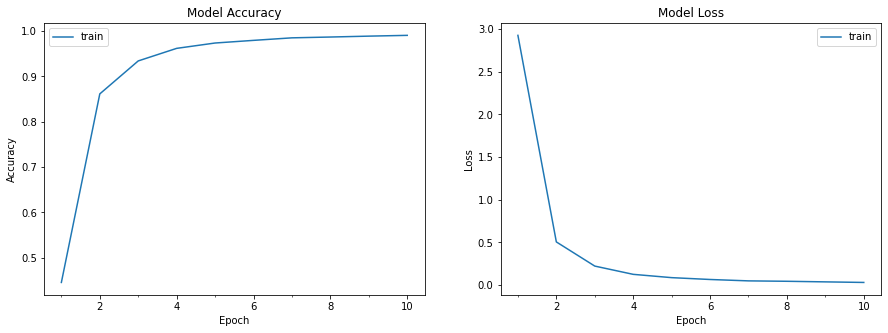

454/454 [==============================] - 28s 61ms/step


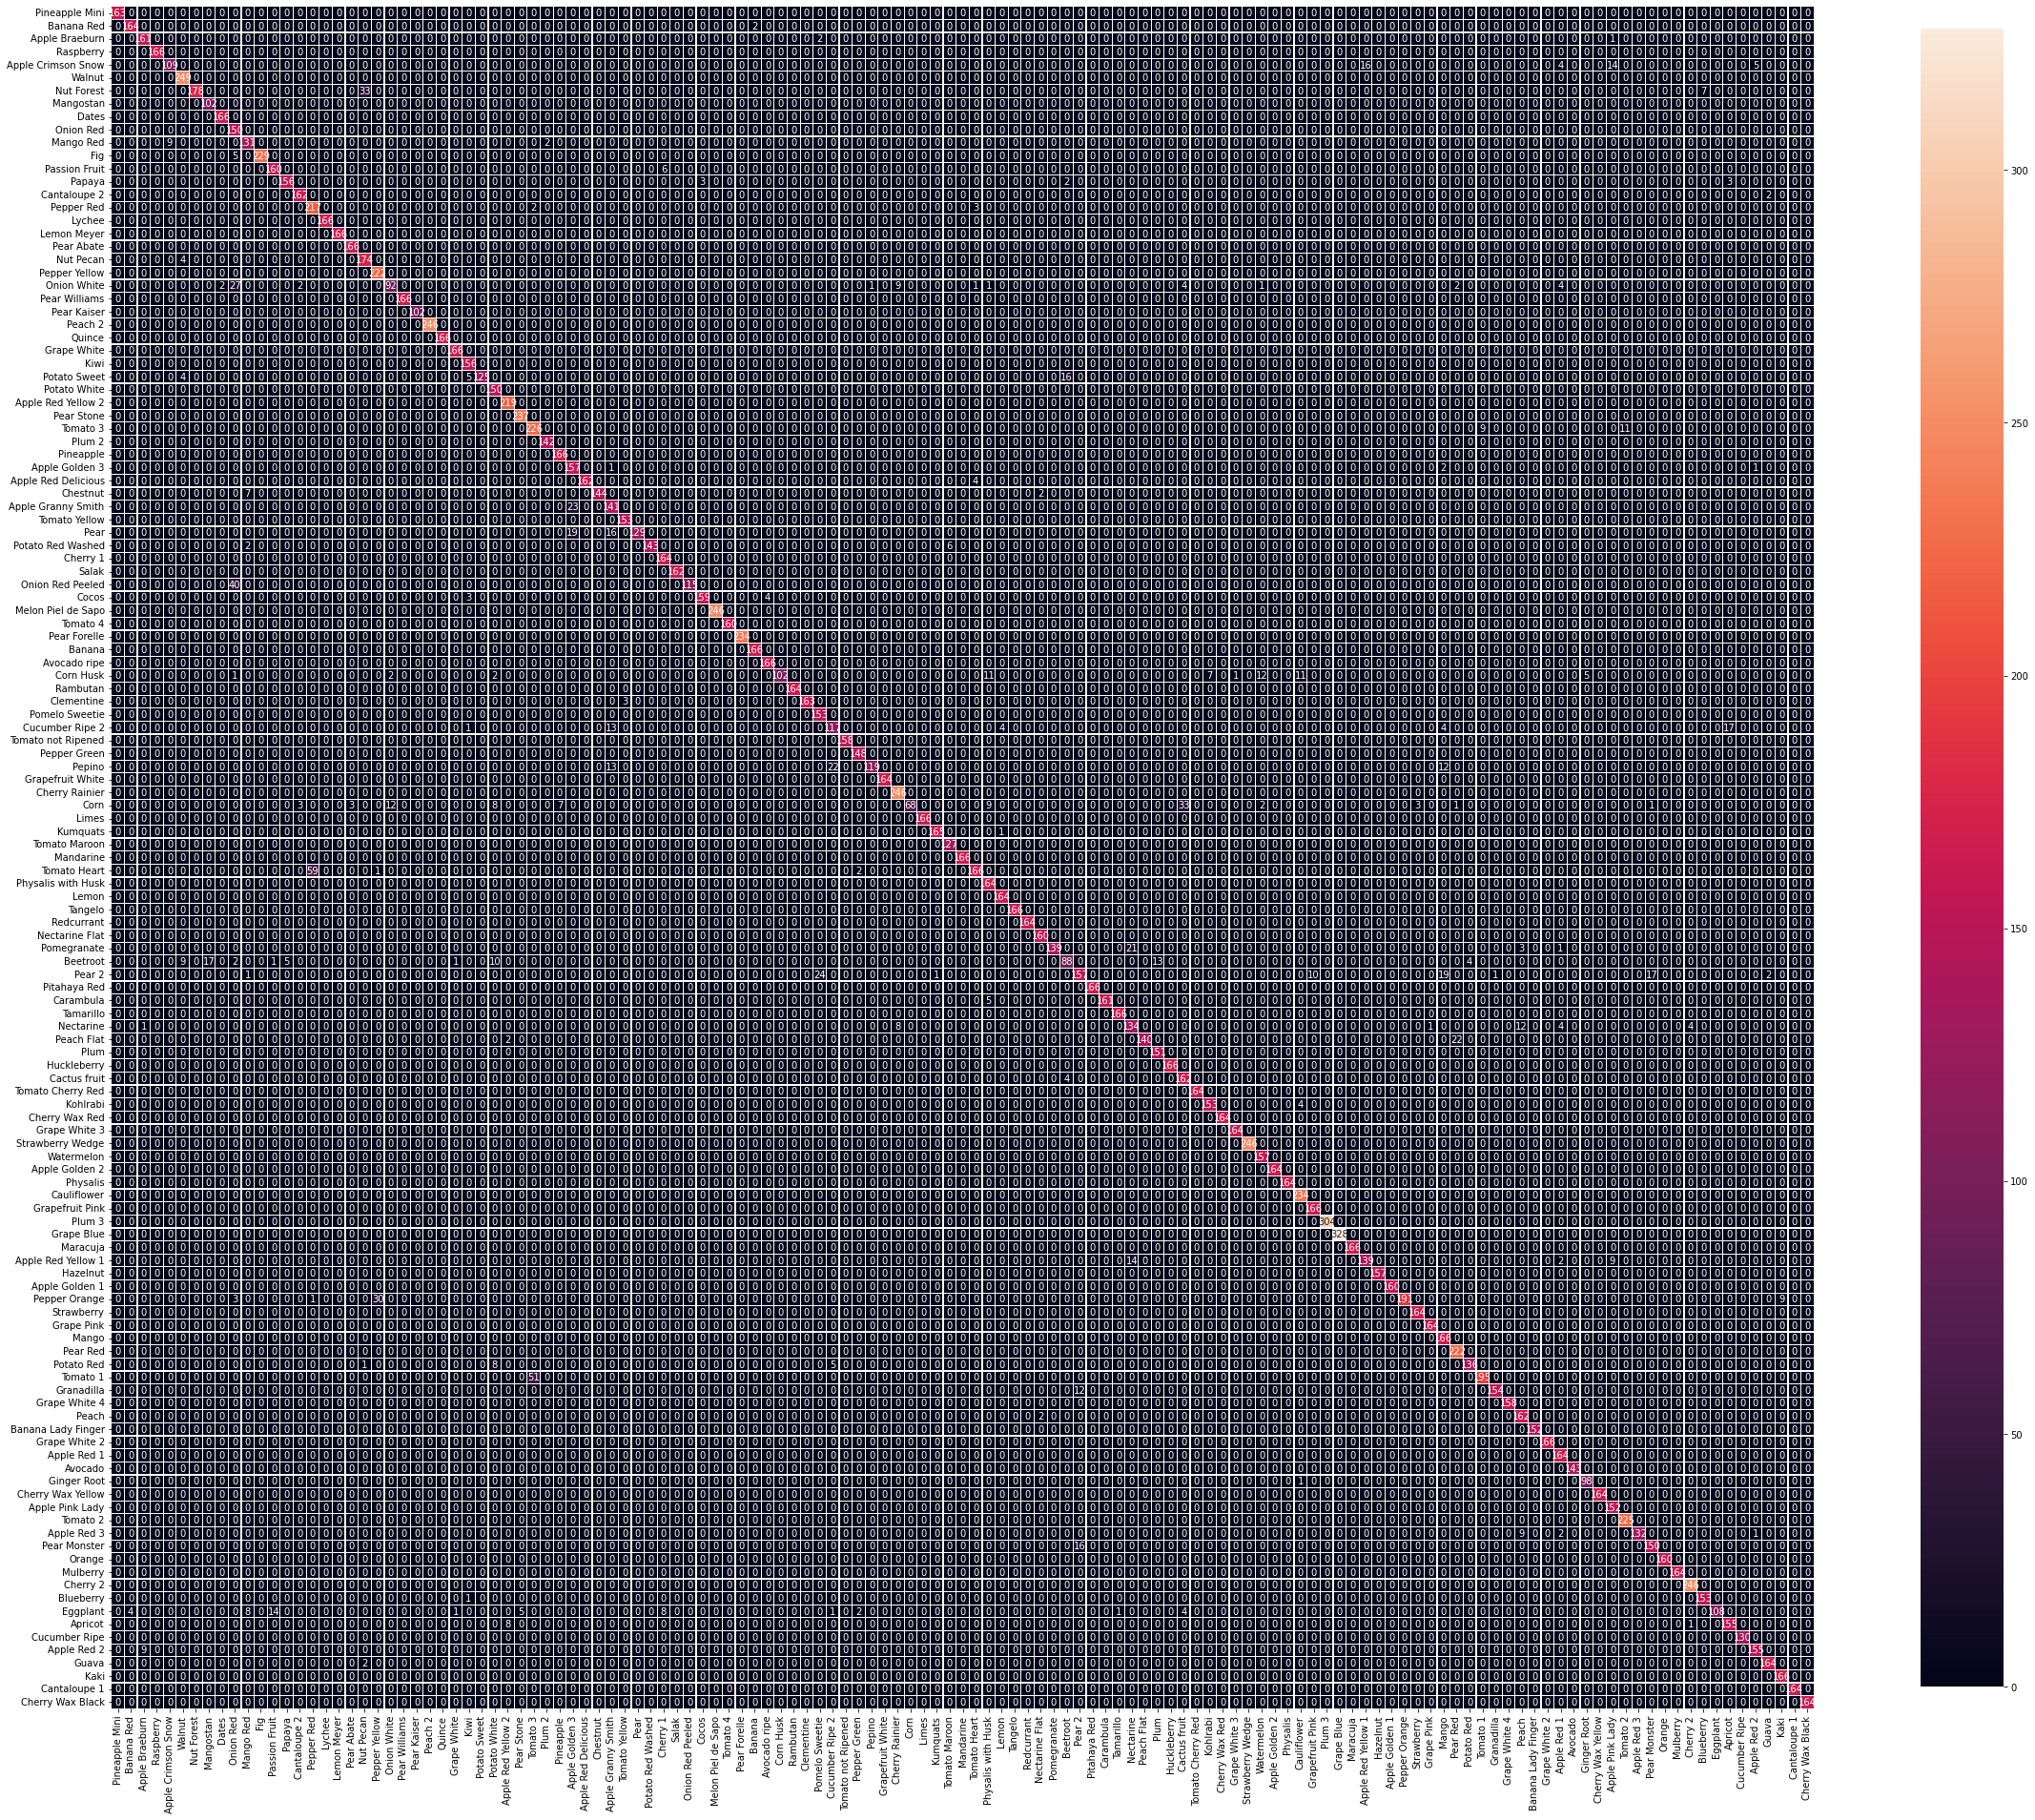

In [ ]:
train_and_evaluate_model(model_VGG16, name="fruit -360 VGG16")

## ResNet50

In [ ]:
#wandb.init(project="Uni3", name="ResNet50")

wandb: Currently logged in as: talesv. Use `wandb login --relogin` to force relogin


In [ ]:
from tensorflow.keras.applications import ResNet50

resnet50 = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(100, 100, 3)))

fullyConnected = FCHeadNet.build(resnet50, num_classes)

model_resnet50 = Model(inputs=resnet50.input, outputs=fullyConnected)
for layer in resnet50.layers:
	layer.trainable = False

model_resnet50.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizati

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1_conv[0][0]']       

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adadelta.py:77: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adadelta, self).__init__(name, **kwargs)


1354/1354 [==============================] - ETA: 0s - loss: 0.5159 - acc: 0.8712
Epoch 1: loss improved from inf to 0.51589, saving model to output_files/fruit -360 ResNet50/model.h5
1354/1354 [==============================] - 218s 158ms/step - loss: 0.5159 - acc: 0.8712 - lr: 0.1000
Epoch 2/10
1354/1354 [==============================] - ETA: 0s - loss: 0.0581 - acc: 0.9823
Epoch 2: loss improved from 0.51589 to 0.05810, saving model to output_files/fruit -360 ResNet50/model.h5
1354/1354 [==============================] - 212s 157ms/step - loss: 0.0581 - acc: 0.9823 - lr: 0.1000
Epoch 3/10
1354/1354 [==============================] - ETA: 0s - loss: 0.0290 - acc: 0.9909
Epoch 3: loss improved from 0.05810 to 0.02896, saving model to output_files/fruit -360 ResNet50/model.h5
1354/1354 [==============================] - 212s 157ms/step - loss: 0.0290 - acc: 0.9909 - lr: 0.1000
Epoch 4/10
1354/1354 [==============================] - ETA: 0s - loss: 0.0207 - acc: 0.9936
Epoch 4: loss im

<ipython-input-7-36db8eb050a1>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1, len(model_history.history["acc"]) + 1), len(model_history.history["acc"]))
<ipython-input-7-36db8eb050a1>:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1, len(model_history.history["loss"]) + 1), len(model_history.history["loss"]))


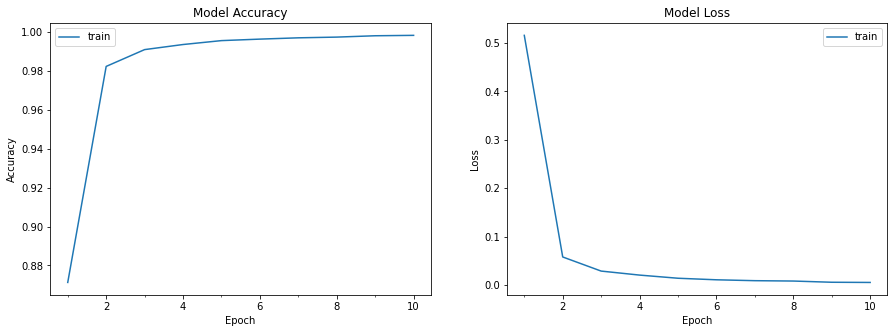

454/454 [==============================] - 21s 45ms/step


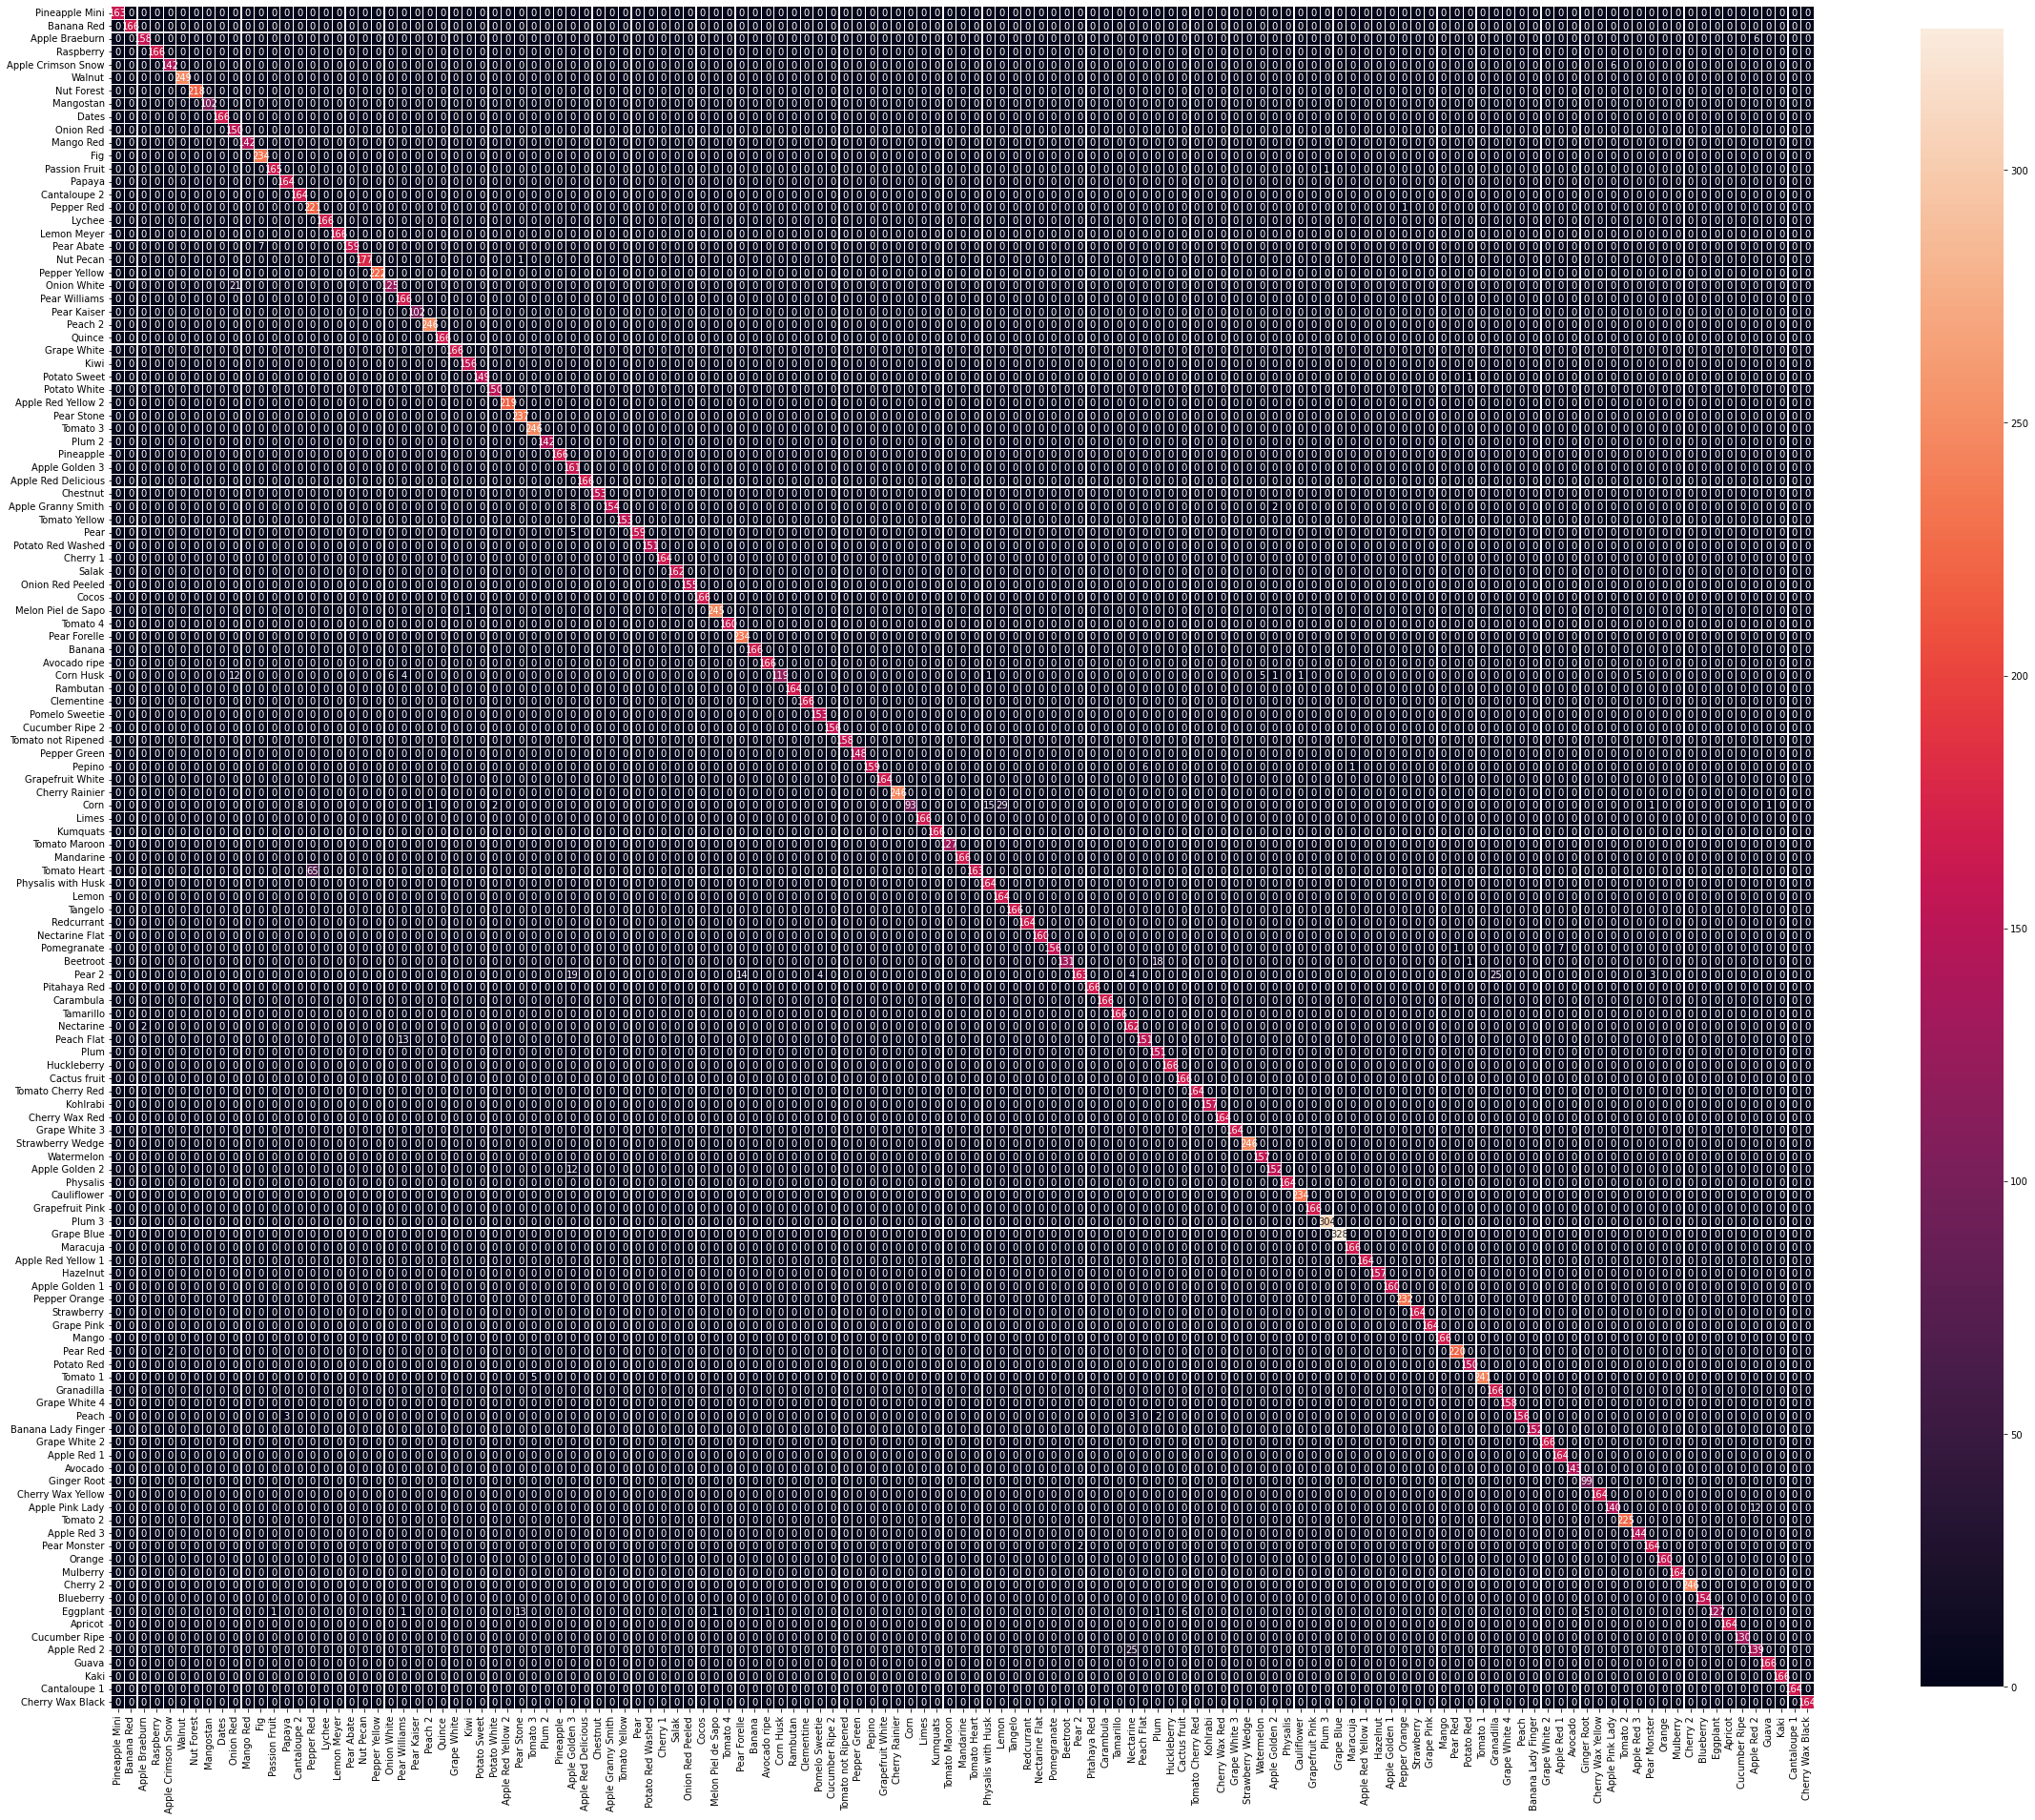

In [ ]:
train_and_evaluate_model(model_resnet50, name="fruit -360 ResNet50")

## MobileNet

In [ ]:
#wandb.init(project="Uni3", name="MobileNet")

acc,▁▇████████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▁▁▁▁▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁
acc,0.9984
epoch,9
loss,0.00524
lr,0.1


In [ ]:
from tensorflow.keras.applications import MobileNet

mobilenet = MobileNet(weights="imagenet", include_top=False, input_tensor=Input(shape=(100, 100, 3)))

fullyConnected = FCHeadNet.build(mobilenet, num_classes)

model_mobilenet = Model(inputs=mobilenet.input, outputs=fullyConnected)
for layer in mobilenet.layers:
	layer.trainable = False

model_mobilenet.summary()

17225924/17225924 [==============================] - 1s 0us/step
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 50, 50, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 50, 50, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 50, 50, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 50, 50, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 50, 50, 32)       128  

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 50, 50, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 50, 50, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 50, 50, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 50, 50, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 50, 50, 32)       128       
 ation)                                                    

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adadelta.py:77: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adadelta, self).__init__(name, **kwargs)


1354/1354 [==============================] - ETA: 0s - loss: 1.9818 - acc: 0.5131
Epoch 1: loss improved from inf to 1.98175, saving model to output_files/fruit -360 MobileNet/model.h5
1354/1354 [==============================] - 173s 126ms/step - loss: 1.9818 - acc: 0.5131 - lr: 0.1000
Epoch 2/10
1354/1354 [==============================] - ETA: 0s - loss: 0.8115 - acc: 0.7646
Epoch 2: loss improved from 1.98175 to 0.81145, saving model to output_files/fruit -360 MobileNet/model.h5
1354/1354 [==============================] - 171s 126ms/step - loss: 0.8115 - acc: 0.7646 - lr: 0.1000
Epoch 3/10
1354/1354 [==============================] - ETA: 0s - loss: 0.5369 - acc: 0.8387
Epoch 3: loss improved from 0.81145 to 0.53687, saving model to output_files/fruit -360 MobileNet/model.h5
1354/1354 [==============================] - 170s 126ms/step - loss: 0.5369 - acc: 0.8387 - lr: 0.1000
Epoch 4/10
1354/1354 [==============================] - ETA: 0s - loss: 0.4011 - acc: 0.8756
Epoch 4: loss

<ipython-input-7-36db8eb050a1>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1, len(model_history.history["acc"]) + 1), len(model_history.history["acc"]))
<ipython-input-7-36db8eb050a1>:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1, len(model_history.history["loss"]) + 1), len(model_history.history["loss"]))


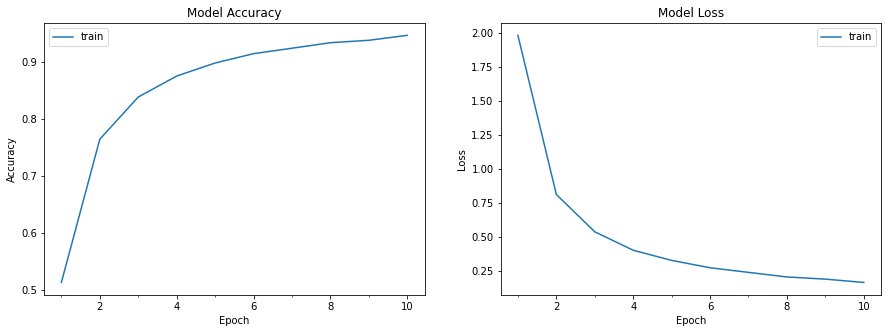

454/454 [==============================] - 14s 29ms/step


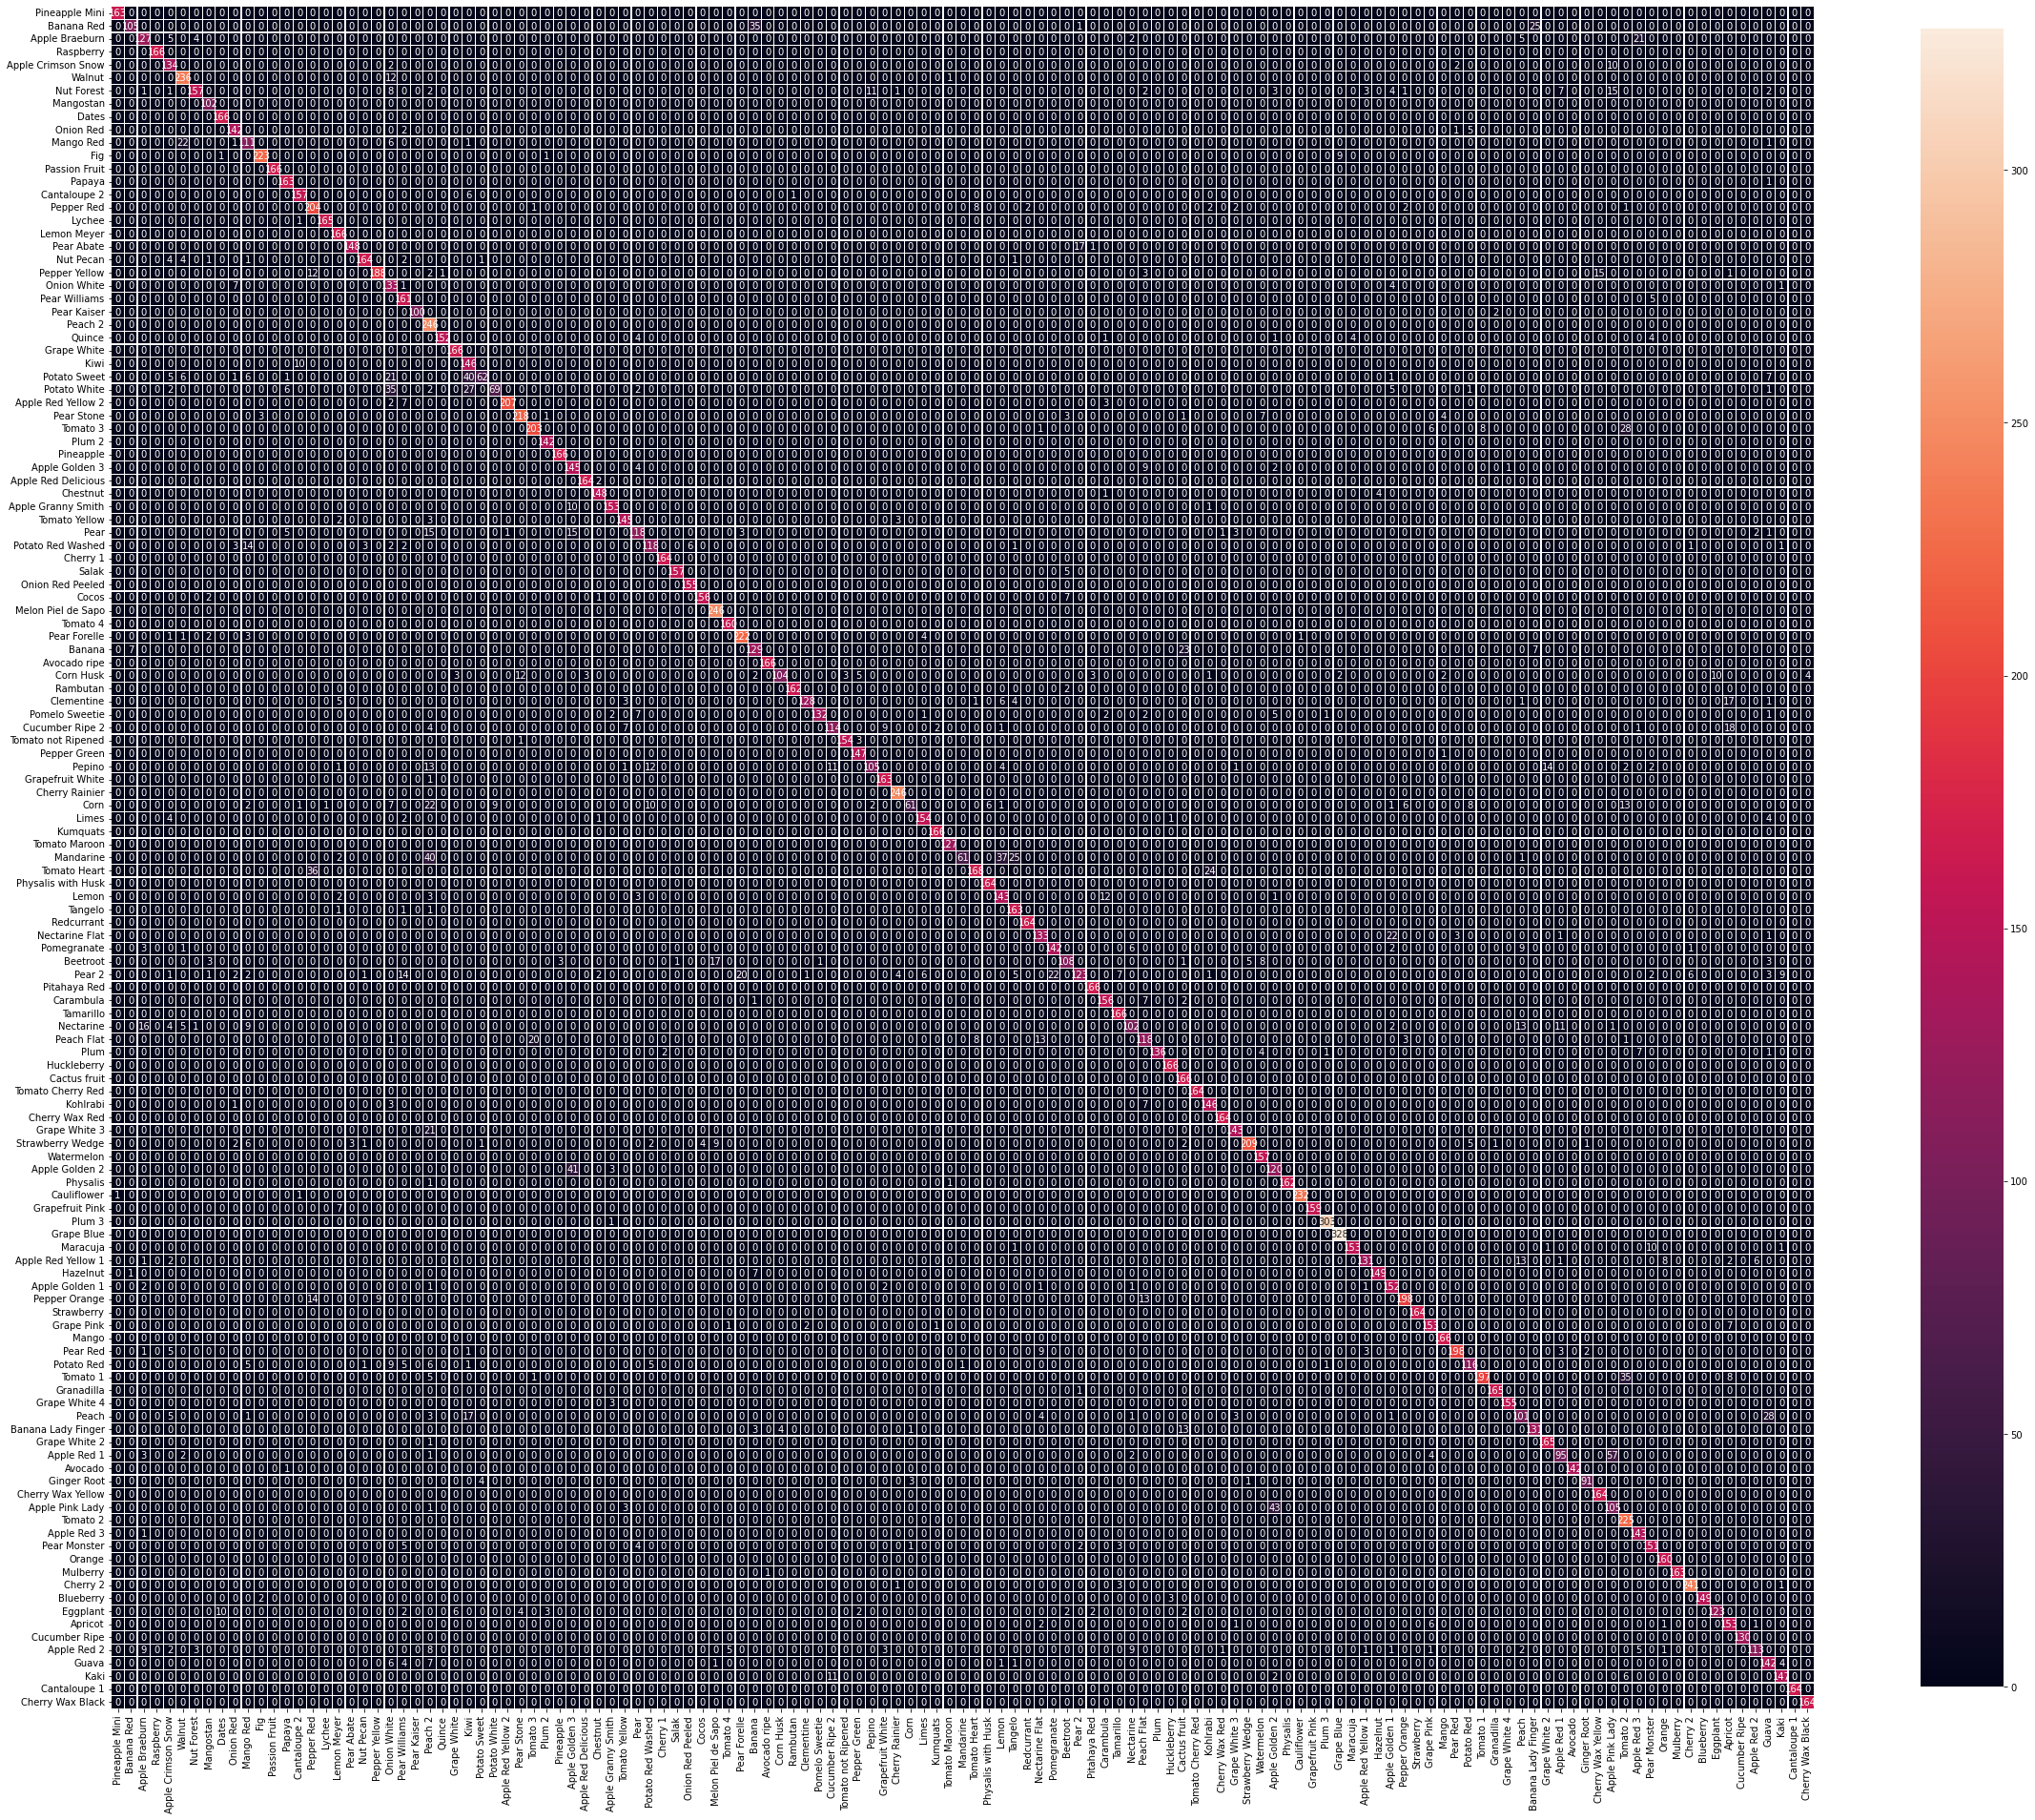

In [ ]:
train_and_evaluate_model(model_mobilenet, name="fruit -360 MobileNet")

#Testes em figuras diferentes

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array 
import numpy

## Imagem 1 - Bananas(lady_finger)

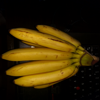

In [ ]:
img1 = load_img("/content/Bananas(lady_finger)1.jpg")
img1 = img1.resize((100, 100))
img1

In [ ]:
img1 = img_to_array(img1) 

img1 = img1.reshape( -1,100, 100,3)

### Predição CNN

In [ ]:
prediction = model.predict(img1)

print(labels[numpy.argmax(prediction)])

1/1 [==============================] - 0s 17ms/step
Strawberry


### Predição VGG16

In [ ]:
prediction = model_VGG16.predict(img1)

print(labels[numpy.argmax(prediction)])

1/1 [==============================] - 0s 468ms/step
Pear Red


### Predição ResNet50

In [ ]:
prediction = model_resnet50.predict(img1)

print(labels[numpy.argmax(prediction)])

1/1 [==============================] - 1s 1s/step
Physalis with Husk


### Predição MobileNet

In [ ]:
prediction = model_mobilenet.predict(img1)

print(labels[numpy.argmax(prediction)])

1/1 [==============================] - 1s 568ms/step
Pear Abate


## Imagem 2 - Bananas

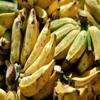

In [ ]:
img2 = load_img("/content/bananas.jpg")
img2 = img2.resize((100, 100))
img2

In [ ]:
img2 = img_to_array(img2) 

img2 = img2.reshape( -1,100, 100,3)

### Predição CNN

In [ ]:
prediction = model.predict(img2)

print(labels[numpy.argmax(prediction)])

1/1 [==============================] - 0s 16ms/step
Cucumber Ripe


### Predição VGG16

In [ ]:
prediction = model_VGG16.predict(img2)

print(labels[numpy.argmax(prediction)])

1/1 [==============================] - 0s 16ms/step
Pepper Red


### Predição ResNet50

In [ ]:
prediction = model_resnet50.predict(img2)

print(labels[numpy.argmax(prediction)])

1/1 [==============================] - 0s 21ms/step
Pineapple Mini


### Predição MobileNet

In [ ]:
prediction = model_mobilenet.predict(img2)

print(labels[numpy.argmax(prediction)])

1/1 [==============================] - 0s 17ms/step
Banana Lady Finger


## Imagem 3 - Frutas Variadas

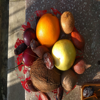

In [ ]:
img3 = load_img("/content/cocos_kiwi_orange_dates_salak_plum_tamarilo_maracuja2.jpg")
img3 = img3.resize((100, 100))
img3

In [ ]:
img3 = img_to_array(img3) 

img3 = img3.reshape( -1,100, 100,3)

### Predição CNN

In [ ]:
prediction = model.predict(img3)

print(labels[numpy.argmax(prediction)])

1/1 [==============================] - 0s 16ms/step
Pitahaya Red


### Predição VGG16

In [ ]:
prediction = model_VGG16.predict(img3)

print(labels[numpy.argmax(prediction)])

1/1 [==============================] - 0s 18ms/step
Pepper Red


### Predição ResNet50

In [ ]:
prediction = model_resnet50.predict(img3)

print(labels[numpy.argmax(prediction)])

1/1 [==============================] - 0s 22ms/step
Pineapple Mini


### Predição MobileNet

In [ ]:
prediction = model_mobilenet.predict(img3)

print(labels[numpy.argmax(prediction)])

1/1 [==============================] - 0s 16ms/step
Pepper Green


## Imagem 4 - Uvas

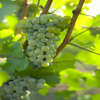

In [ ]:
img4 = load_img("/content/grapes.jpg")
img4 = img4.resize((100, 100))
img4

In [ ]:
img4 = img_to_array(img4) 

img4 = img4.reshape( -1,100, 100,3)

### Predição CNN

In [ ]:
prediction = model.predict(img4)

print(labels[numpy.argmax(prediction)])

1/1 [==============================] - 0s 18ms/step
Cauliflower


### Predição VGG16

In [ ]:
prediction = model_VGG16.predict(img4)

print(labels[numpy.argmax(prediction)])

1/1 [==============================] - 0s 17ms/step
Pepper Red


### Predição ResNet50

In [ ]:
prediction = model_resnet50.predict(img4)

print(labels[numpy.argmax(prediction)])

1/1 [==============================] - 0s 20ms/step
Pineapple Mini


### Predição MobileNet

In [ ]:
prediction = model_mobilenet.predict(img4)

print(labels[numpy.argmax(prediction)])

1/1 [==============================] - 0s 19ms/step
Banana Red


## Imagem 5 - Maçã

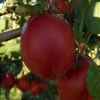

In [ ]:
img5 = load_img("/content/mcintosh-apple.jpg")
img5 = img5.resize((100, 100))
img5

In [ ]:
img5 = img_to_array(img5) 

img5 = img5.reshape( -1,100, 100,3)

### Predição CNN

In [ ]:
prediction = model.predict(img5)

print(labels[numpy.argmax(prediction)])

1/1 [==============================] - 0s 15ms/step
Strawberry


### Predição VGG16

In [ ]:
prediction = model_VGG16.predict(img5)

print(labels[numpy.argmax(prediction)])

1/1 [==============================] - 0s 18ms/step
Onion Red Peeled


### Predição ResNet50

In [ ]:
prediction = model_resnet50.predict(img5)

print(labels[numpy.argmax(prediction)])

1/1 [==============================] - 0s 21ms/step
Tomato not Ripened


### Predição MobileNet

In [ ]:
prediction = model_mobilenet.predict(img5)

print(labels[numpy.argmax(prediction)])

1/1 [==============================] - 0s 17ms/step
Carambula
